# Q1.Simualte a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates. 

In [1]:
import pandas as pd
import numpy as np
import random
import graphviz as gr
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
random.seed(10)

## · DGP

In [2]:
def fn_variance(data, ddof=0):
    n = len(data)
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)

In [3]:
def fn_generate_cov(dim):
    acc  = []
    for i in range(dim):
        row = np.ones((1,dim)) * corr
        row[0][i] = 1
        acc.append(row)
    return np.concatenate(acc,axis=0)

def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1)))
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

    return Y

def fn_randomize_treatment(N,p=0.5):
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])


In [4]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
    else:
        conf_mult = 0
        
    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    C = allX[:,1].reshape([N,1]) # confounder
    X = allX[:,2:] # observed covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err



In [5]:
def fn_tauhat_means(Yt,Yc):
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)
    return (tauhat,se_tauhat)

def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)
    rmse = np.sqrt(np.mean(b**2))
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):
    """
    tau - treatment effect
    Nrange - range of sample sizes
    p - number of covariates generated
    p0 - number of covariates included
    corr - correlation between covariates
    conf - confounder
    """
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            #No X's included
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs = X[:,:p0]
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)


In [6]:
np.random.seed(10)
n = 1000
T = np.random.binomial(1, 0.5, n)
X1 = np.random.normal(20,5,n)
X2 = np.random.normal(20,5,n)
X3 = np.random.normal(20,5,n)
Y = np.random.normal(1 +1*T+1*X1+1*X2+1*X3, 5).astype(int)
data1 = pd.DataFrame(dict(T = T,
                            X1 = X1,
                            X2 = X2,
                            X3 = X3,
                            Y = Y))
data1.to_csv("data-covariates.csv", index=False)

## · DAG

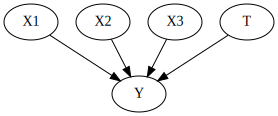

In [7]:
g = gr.Digraph()

g.edge("X1", "Y")
g.edge("X2", "Y")
g.edge("X3", "Y")
g.edge("T", "Y")

g

## · Run a Monte Carlo experiment 

### a. You do not control for any covariates

$Y_i = \tau*T_i+e_i$

$e_i \sim N(0,\sigma^2)$

In [8]:
tau=2
corr = .5
conf=False
p = 10
p0 = 0
Nrange = range(10,1000,5)
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

100%|████████████████████████████████████████| 198/198 [00:00<00:00, 448.04it/s]


In [9]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 182.98it/s]


In [10]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')
    

N=100: bias=-0.0013812918129380175, RMSE=0.19755259359772204, size=0.049
N=1000: bias=0.0002580789609925882, RMSE=0.06216041031105066, size=0.0445


### b.You control for all the covariates that affect the outcome

$Y_i = \tau*T_i+\beta'*X_i+e_i$

$e_i \sim N(0,\sigma^2)$

In [11]:
tau=2
corr = .5
conf=False
p = 10
p0 = 10
flagX=1

In [12]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T = fn_generate_data(tau,N,10,10,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 184.44it/s]


In [13]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.058455335977126655, RMSE=8.010988468295231, size=0.0485
N=1000: bias=-0.07220545318704916, RMSE=2.62637391760449, size=0.049


## · Example of a real-life situation 

X(covariates): student's age, gender,family background 

T: small size class(<=20) or not

Y: student's performance

I want to study the effect of small size class on students' performance. To rule out the effects of other covariates on students' performance , I should control for those variables, such as student's age, gender and family background.

# Q2. Simulate a DGP with a confounder (common cause)

$Y_i = \tau*T_i+0.8*C+e_i$  C: Confounder

$T_i =0.5*C$

## · DGP

In [14]:
def fn_generate_data_conf(tau,N,p,corr):

    nvar = p+1 
    corr = 0.5 
 
    X = fn_generate_multnorm(N,corr,nvar)
    C = X[:,1].reshape([N,1])  
    T = fn_randomize_treatment(N) 
    err = np.random.normal(0,1,[N,1])
    Yab = tau*T+0.8*C+err
    Tab = T+0.5*C
    
    return (Yab,Tab,C)

In [15]:
random.seed(10)

tau = 2
corr = 0.5
p = 10
conf=True
Nrange = range(10,1000,5)
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf)

Y,T,C = fn_generate_data_conf(tau,N,p,corr)
data = np.concatenate([Y,T,C],axis = 1)
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'Confounder']
data.to_csv('data-confounder.csv')


100%|████████████████████████████████████████| 198/198 [00:00<00:00, 459.28it/s]


## · DAG

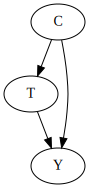

In [16]:
g = gr.Digraph()

g.edge("T", "Y")
g.edge("C", "Y")
g.edge("C", "T")

g

## · Run a Monte Carlo experiment

### a.You fail to control for the confounder

In [17]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:11<00:00, 169.84it/s]


In [18]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.1254042807202189, RMSE=0.17665819449289807, size=0.218
N=1000: bias=-0.13123813341968138, RMSE=0.14085070684205012, size=0.866


### b.You do control for the confounder

In [19]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Y,T,C = fn_generate_data_conf(tau,N,p,corr)
        covars = np.concatenate([T,C],axis = 1)
        mod = sm.OLS(Y,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }


100%|██████████████████████████████████████| 2000/2000 [00:11<00:00, 167.85it/s]


In [20]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0012971666607536178, RMSE=0.1384009918016348, size=0.0555
N=1000: bias=-0.0016538399535356801, RMSE=0.04551121044391871, size=0.053


## · Example of a real-life situation

C: monthly salary

T: have a car or not

Y: monthly expense

I want to study the effect of having a car or not on monthly expense. Since montly salary is a confounder, which causes both having a car or not and monthly expense, I control for monthly salary to ensure the independence between T and Y.

# Q3.Simulate a DGP with selection bias into the treatment (variable in between the path from thetreatment to the outcome)

$Y_i = \tau*T_i+e_i$  

$X_i =0.5*Y_i+0.4*T_i$

## · DGP

In [21]:
def fn_generate_data_sele(tau,N,p,corr):

    nvar = p+1 # 1 for selection bias
    corr = 0.5 # correlation for multivariate normal
 
    allX = fn_generate_multnorm(N,corr,nvar)
     
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    U = np.random.normal(0,1,[N,1])
    Yab = tau*T+err
    Xab = 0.4*T+0.5*Yab+U

    return (Yab,T,Xab)

In [22]:
tau = 2
corr = .5
p = 10
N = 1000

Y,T,X = fn_generate_data_sele(tau,N,p,corr)

data = np.concatenate([Y,T,X],axis = 1)
data = pd.DataFrame(data)
data.columns = ['Y', 'T', 'X']
data.to_csv('data-selection.csv')

## · DAG

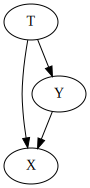

In [23]:
g = gr.Digraph()

g.edge("T", "X")
g.edge("T", "Y")
g.edge("Y", "X")

g

## · Run a Monte Carlo experiment

### a. You control for the variable in between the path from cause to effect

In [24]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Xexp = fn_generate_data_sele(tau,N,p,corr)
        covars = np.concatenate([T,Xexp],axis = 1)
        mod = sm.OLS(Yexp,covars)
        res = mod.fit()
        tauhat = res.params[0]
        se_tauhat = res.HC1_se[0]
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }


100%|██████████████████████████████████████| 2000/2000 [00:11<00:00, 167.18it/s]


In [25]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.5704068073396732, RMSE=0.5948695742293214, size=0.914
N=1000: bias=-0.5603346292305649, RMSE=0.5628194122803005, size=1.0


### b. You do not control for the variable in between the path from cause to effect

In [26]:
estDict = {}
R = 2000
for N in [100,1000]:
    tauhats = []
    sehats = []
    for r in tqdm(range(R)):
        Yexp,T,Xab = fn_generate_data_sele(tau,N,p,corr)   
        Yt = Yexp[np.where(T==1)[0],:]
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
        
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████████████████████████████████| 2000/2000 [00:10<00:00, 185.36it/s]


In [27]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.00884967405428685, RMSE=0.20156559080701186, size=0.06
N=1000: bias=0.001100311161735364, RMSE=0.06257440705402993, size=0.05


## · Example of a real-life situation

X: earings

T: motivated characteristic

Y: take a job training programme 

I want to study the effect of motivated characteristic on the possibility of taking a job training  programme .If I conditional on earnings, then I will introduce selection bias because people selected into different earning levels denpend on motivated characteristic and taking a job training programme or not. Therefore, motivated characteristic and taking a job training  programme become no longer independent.